# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]
type(brain)

ReacherBrain


unityagents.brain.BrainParameters

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print("states shape : ", states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
states shape :  (1, 33)
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## DDPG Deep Deterministic Policy Gradients

In [5]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import copy
import matplotlib.pyplot as plt
%matplotlib inline


### Actor Model

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)
    
class Actor(nn.Module) :
    """
    The Actor network is an approximation of the policy function that maps states to actions
    """
    
    def __init__(self, state_size, action_size, seed, fc1_units = 256, fc2_units = 512, fc3_units = 256) : # ????
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self) :
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return F.tanh(self.fc4(x)) # each action is in the range ]-1, 1[ 
    

### Critic Model

In [7]:
class Critic(nn.Module) :
    """
    The Critic network is an approximation of the action-value function 
    (Q function) that maps state-action pairs to value
    """
    
    def __init__(self, state_size, action_size, seed, fcs1_units = 256, fc2_units = 512, fc3_units = 256, fc4_units = 64) : # ????
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, fc4_units)
        self.fc5 = nn.Linear(fc4_units, 1)
        
        self.reset_parameters()
        
    def reset_parameters(self) :
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(*hidden_init(self.fc4))
        self.fc5.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        xs = F.relu(self.fc1(state))
        x = torch.cat((xs, action), dim = 1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x) 

### DDPG Agent

#### Hyperparameters

In [8]:
BUFFER_SIZE = int(1e5) # Replay buffer size
BATCH_SIZE = 512       # mini batch size
GAMMA = 0.99           # discount factor
TAU = 1e-3             # for soft update of the target parameters
LR_ACTOR = 1e-4        # Learning rate of actor
LR_CRITIC = 1e-3       # Learning rate of critic
UPDATE_EVERY = 8
WEIGHT_DECAY = 0.

#### Device

Determine the device we are running on

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device : ", device)

Current device :  cpu


#### Replay Buffer
The agent learns from past experiences that are stored in a replay buffer. An experience is a named tuple $<s, a, r, s^{'}, done>$. At each step (interaction of the agent with the environment) , the agent stores the response of the environment as a tuple in the replay buffer. The agent also samples at each step (once the replay buffer contains enough experiences) the replay bufferto get a batch of experiences that are used to learn the weights ($\theta, w$) of the actor and critic networks.

In [10]:
class ReplayBuffer :
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen =  buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names = ['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self) :
        experiences = random.sample(self.memory, k = self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones) 
    
    def __len__(self):
        return len(self.memory)
        
                                                                                                        
        
        
        
        
    

#### Noise

In [11]:
class OUNoise :
    def __init__(self, size, seed, mu = 0, theta = 0.15, sigma = 0.2) :
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        
    def reset(self):
        self.state = copy.copy(self.mu)
        
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state
        

#### Agent

In [12]:
class Agent() :
    """
    Interacts with and learns from the environment
    """
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        # Actor network (with target network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        # Critic network (with target network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Noise 
        self.noise = OUNoise(action_size, random_seed)
        # Replay memory
        self.t_step = 0
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    def step(self, state, action, reward, next_state, done):
        """
        save experience in replay memory and use random sample to learn
        """
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 :
            # Learn if enough samples available
            if len(self.memory) > BATCH_SIZE :
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, add_noise = True):
        """
        returns actions for given state as per given policy
        """
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise :
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self) :
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        """
        Updates policy and value parameters using given batch of experience tuples
        Q_targets = r + gamma * critic_target(next_state, actor_target(next_state))
        where 
            actor_target(state) -> action
            critic_target(state, action) -> Qvalue
        Parameters :
            experiences (Tuple(Torch.tensor)) : minibatch of (s, a, r, s', done) tuples 
            gamma (float) : discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # -------------- Update Critic ---------------------------
        # Get predicted next state actions and Qvalues from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Qtargets for current state
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # -------------- Update Actor ----------------------------
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = - self.critic_local(states, actions_pred).mean()  # gradieent ascent for the value !!!
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # -------------- Update target networks ------------------- 
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data +(1.0 - tau) * target_param.data)
        
    

#### Train the agent with DDPG

Episode 50 	Average Score : 1.077
Episode 100 	Average Score : 2.188
Episode 150 	Average Score : 6.666
Episode 200 	Average Score : 16.477
Episode 250 	Average Score : 28.188
Episode 300 	Average Score : 36.488
Episode 350 	Average Score : 37.866
Episode 400 	Average Score : 36.100
Episode 450 	Average Score : 37.222
Episode 500 	Average Score : 34.144
Episode 550 	Average Score : 35.988
Episode 600 	Average Score : 35.922
Episode 650 	Average Score : 33.999
Episode 700 	Average Score : 35.877
Episode 750 	Average Score : 35.366
Episode 800 	Average Score : 34.477
Episode 850 	Average Score : 32.933
Episode 900 	Average Score : 34.066
Episode 950 	Average Score : 32.999
Episode 1000 	Average Score : 31.611


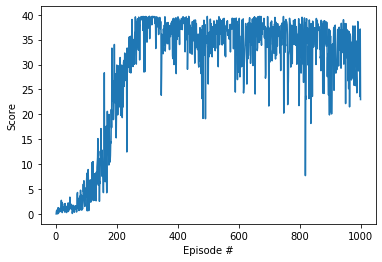

In [13]:
agent = Agent(state_size, action_size, random_seed = 2)

def ddpg(n_episodes = 1000, max_t = 1200, print_every = 50) :
    
    scores_deque = deque(maxlen = print_every)
    scores = []
    
    for i_episode in range(1, n_episodes + 1) :
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0

        for t in range(max_t) : 
            
            action = agent.act(state, add_noise = False)
            
            env_info = env.step(action.reshape(1,-1))[brain_name]  # send all actions to tne environment
            next_state = env_info.vector_observations[0]           # get next state
            reward = env_info.rewards[0]                           # get reward 
            done = env_info.local_done[0]                          # see if episode finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            if done :
                break
        
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {} \t Average Score : {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if i_episode % print_every == 0 :
            print('\rEpisode {} \tAverage Score : {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores
    
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [14]:
env.close()

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

## Implement the policy (old)

In [ ]:
# examine the state space 
states = env_info.vector_observations
print(states.shape)
state_size = states.shape[1]


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up the policy as a Neural Nework
# input : state; vector of shape (1,33)
# output : actions, 4 values in range (-1, 1); vector of shape (1,4)    

class Policy(nn.Module):
    
    def __init__(self):
        
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(33, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 4)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.tanh(x)
    
policy = Policy().to(device)
# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

## Collect Trajectories

In [ ]:
def collect_trajectory(policy, tmax=100, nrand=5):

    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    
    state_seq = []
    reward_seq = []
    action_seq = []
    
    for _ in range(nrand) :    
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]
        
    states = env_info.vector_observations                  # get the current state (for each agent)

    for t in range(tmax) :
        i_states = torch.from_numpy(states).float().to(device)
        actions = policy(i_states).squeeze().cpu().detach().numpy()
    
        # take a step
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        states = next_states
    
        if np.any(dones):
            break
    
        # store the results
        state_seq.append(i_states)
        reward_seq.append(rewards)
        action_seq.append(actions)
        
    return state_seq, action_seq, reward_seq

# Trying it
states, actions, rewards = collect_trajectory(policy, tmax=3)
print("sequence of states : ", states)
print("sequence of actions : ", actions)
print("sequence of rewards : ", rewards)

## Surrogate Function

In [ ]:
# clipped surrogate function
# similar as -policy_loss for REINFORCE, but for PPO
